## <center> Coding Discussion 06

### Dependencies

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

### Data

In [2]:
# load test data
test_dat = pd.read_csv("test_data_cd.csv")

# check shape
test_dat.shape

(14531, 39)

In [3]:
# load training data
train_dat = pd.read_csv("train_data_cd.csv")

# check shape
train_dat.shape

(43590, 39)

In [4]:
# available features
list(train_dat)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

### Check Missingness in Training Data

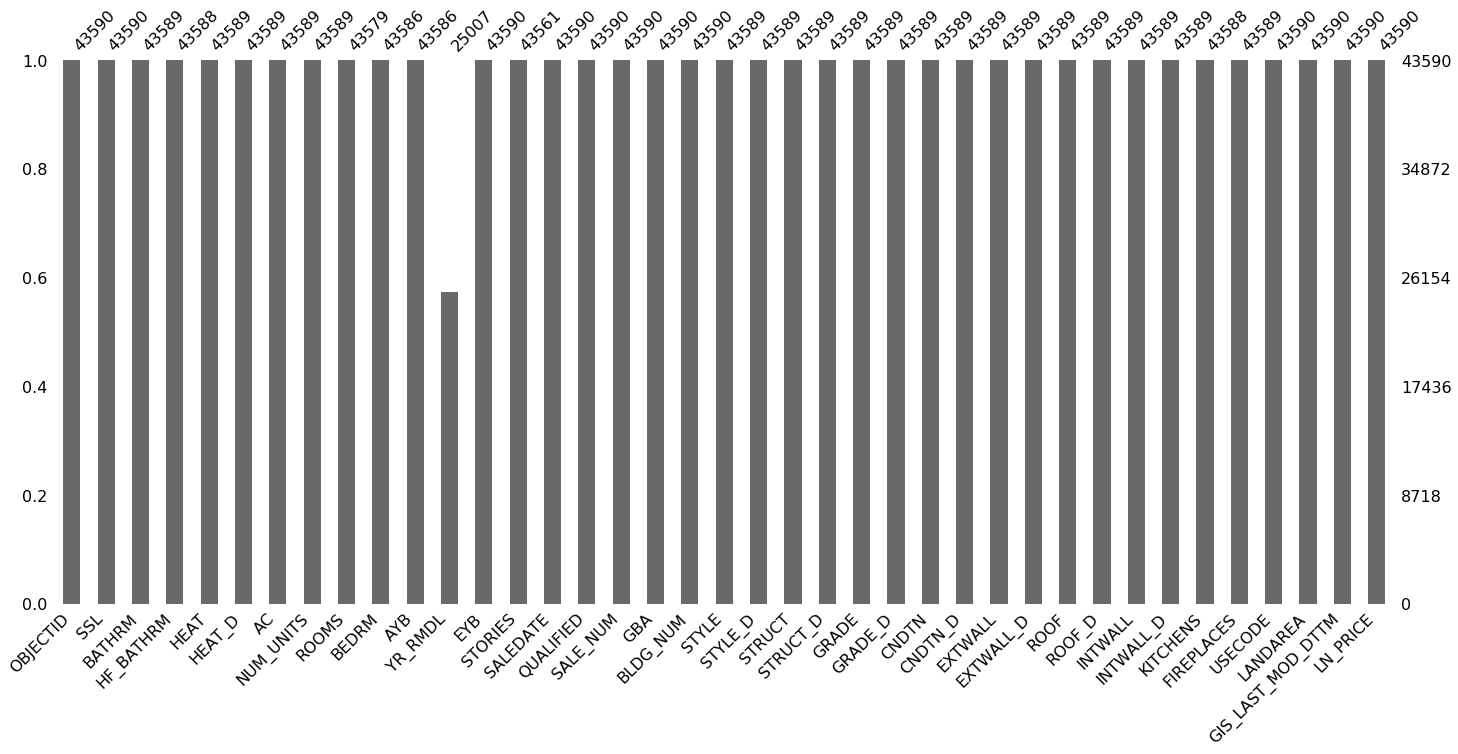

In [5]:
# look at missingness in the training data
miss.bar(train_dat)

In [6]:
# Total missing values for each feature in the training data
train_dat.isnull().sum()

OBJECTID                 0
SSL                      0
BATHRM                   1
HF_BATHRM                2
HEAT                     1
HEAT_D                   1
AC                       1
NUM_UNITS                1
ROOMS                   11
BEDRM                    4
AYB                      4
YR_RMDL              18583
EYB                      0
STORIES                 29
SALEDATE                 0
QUALIFIED                0
SALE_NUM                 0
GBA                      0
BLDG_NUM                 0
STYLE                    1
STYLE_D                  1
STRUCT                   1
STRUCT_D                 1
GRADE                    1
GRADE_D                  1
CNDTN                    1
CNDTN_D                  1
EXTWALL                  1
EXTWALL_D                1
ROOF                     1
ROOF_D                   1
INTWALL                  1
INTWALL_D                1
KITCHENS                 2
FIREPLACES               1
USECODE                  0
LANDAREA                 0
G

### Check Missingness in Test Data

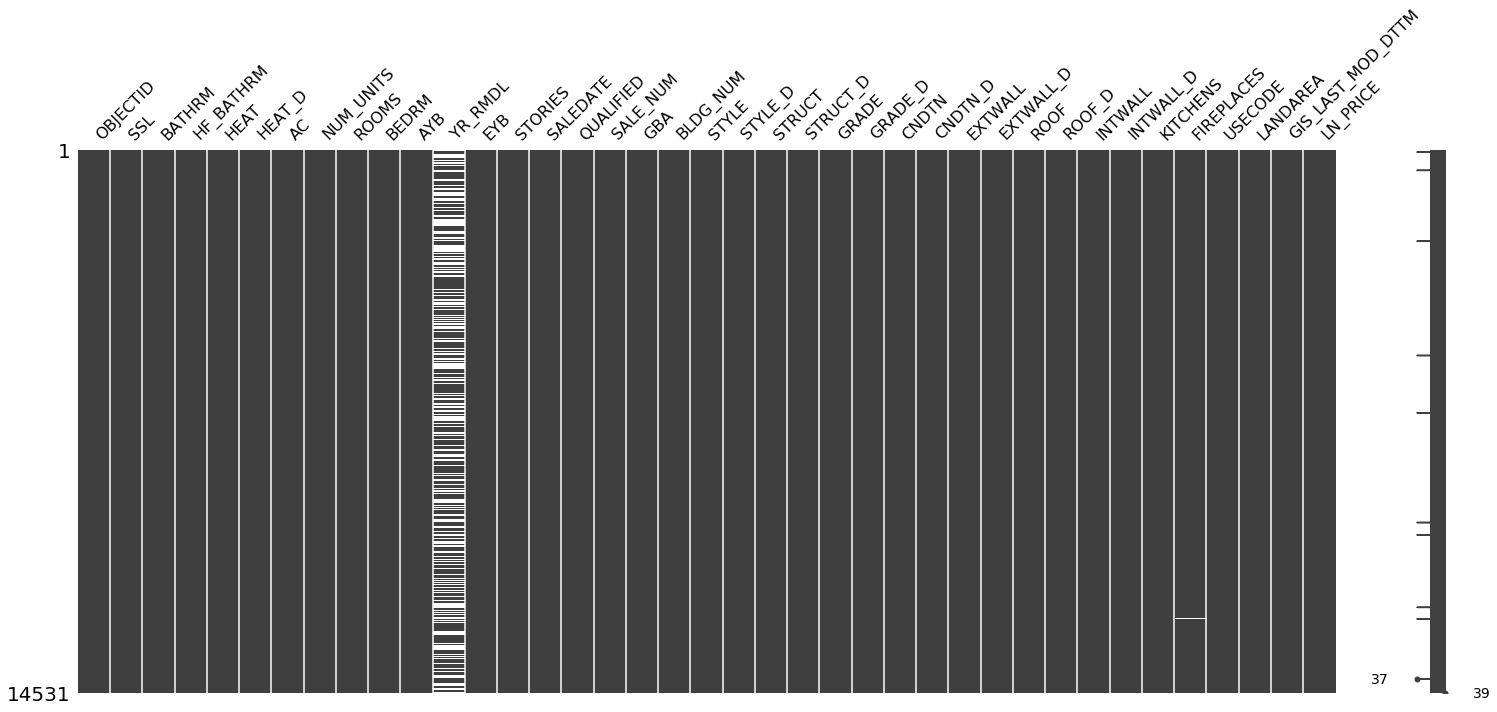

In [7]:
# look at missingness in the test data
miss.matrix(test_dat)

In [8]:
# Total missing values for each feature in the test data
test_dat.isnull().sum()

OBJECTID                0
SSL                     0
BATHRM                  0
HF_BATHRM               0
HEAT                    0
HEAT_D                  0
AC                      0
NUM_UNITS               0
ROOMS                   2
BEDRM                   0
AYB                     1
YR_RMDL              6202
EYB                     0
STORIES                 7
SALEDATE                0
QUALIFIED               0
SALE_NUM                0
GBA                     0
BLDG_NUM                0
STYLE                   0
STYLE_D                 0
STRUCT                  0
STRUCT_D                0
GRADE                   0
GRADE_D                 0
CNDTN                   0
CNDTN_D                 0
EXTWALL                 0
EXTWALL_D               0
ROOF                    0
ROOF_D                  0
INTWALL                 0
INTWALL_D               0
KITCHENS                0
FIREPLACES              1
USECODE                 0
LANDAREA                0
GIS_LAST_MOD_DTTM       0
LN_PRICE    

### Clean Outcome Variable and LAND AREA in both Training and Test Data

In [9]:
# inspect min of ln_price feature in training data
train_dat[['LN_PRICE']].min()

LN_PRICE    0.0
dtype: float64

In [10]:
# inspect min of ln_price feature in test data
test_dat[['LN_PRICE']].min()

LN_PRICE    2.302585
dtype: float64

In [11]:
# inspect min of LAND AREA feature in training data
train_dat[['LANDAREA']].min()

LANDAREA    0
dtype: int64

In [12]:
# inspect min of LAND AREA feature in test data
test_dat[['LANDAREA']].min()

LANDAREA    0
dtype: int64

In [13]:
# include only land area data where land area > 0 before logging land area since log(0) would be undefined.
train_dat = train_dat[train_dat.LANDAREA > 0]
test_dat = test_dat[test_dat.LANDAREA > 0]

In [14]:
# check minimum values of land area in both data sets
print(train_dat[['LANDAREA']].min(),test_dat[['LANDAREA']].min())

LANDAREA    216
dtype: int64 LANDAREA    331
dtype: int64


### Clean Training Data

In [15]:
# Drop all observations where the predictors are missing
train_dat = train_dat[~train_dat.BATHRM.isna()]
train_dat = train_dat[~train_dat.ROOMS.isna()]
train_dat = train_dat[~train_dat.BEDRM.isna()]
train_dat = train_dat[~train_dat.KITCHENS.isna()]
train_dat = train_dat[~train_dat.FIREPLACES.isna()]

### Clean Test Data

In [16]:
# Drop all observations where the predictors are missing
test_dat = test_dat[~test_dat.ROOMS.isna()]
test_dat = test_dat[~test_dat.FIREPLACES.isna()]

### Define Outcome and Predictors

In [17]:
# test data outcome: log selling price 
test_y = test_dat['LN_PRICE'] 

In [18]:
# test data predictors
test_X = test_dat[['BATHRM','ROOMS','BEDRM','KITCHENS','FIREPLACES','LANDAREA']]

# log land area variable
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])

In [19]:
# training data outcome: log selling price
train_y = train_dat['LN_PRICE']

In [20]:
# training data predictors
train_X = train_dat[['BATHRM','ROOMS','BEDRM','KITCHENS','FIREPLACES','LANDAREA']]

# log land area variable
train_X['LANDAREA'] = np.log(train_X['LANDAREA'])

### Explore training data

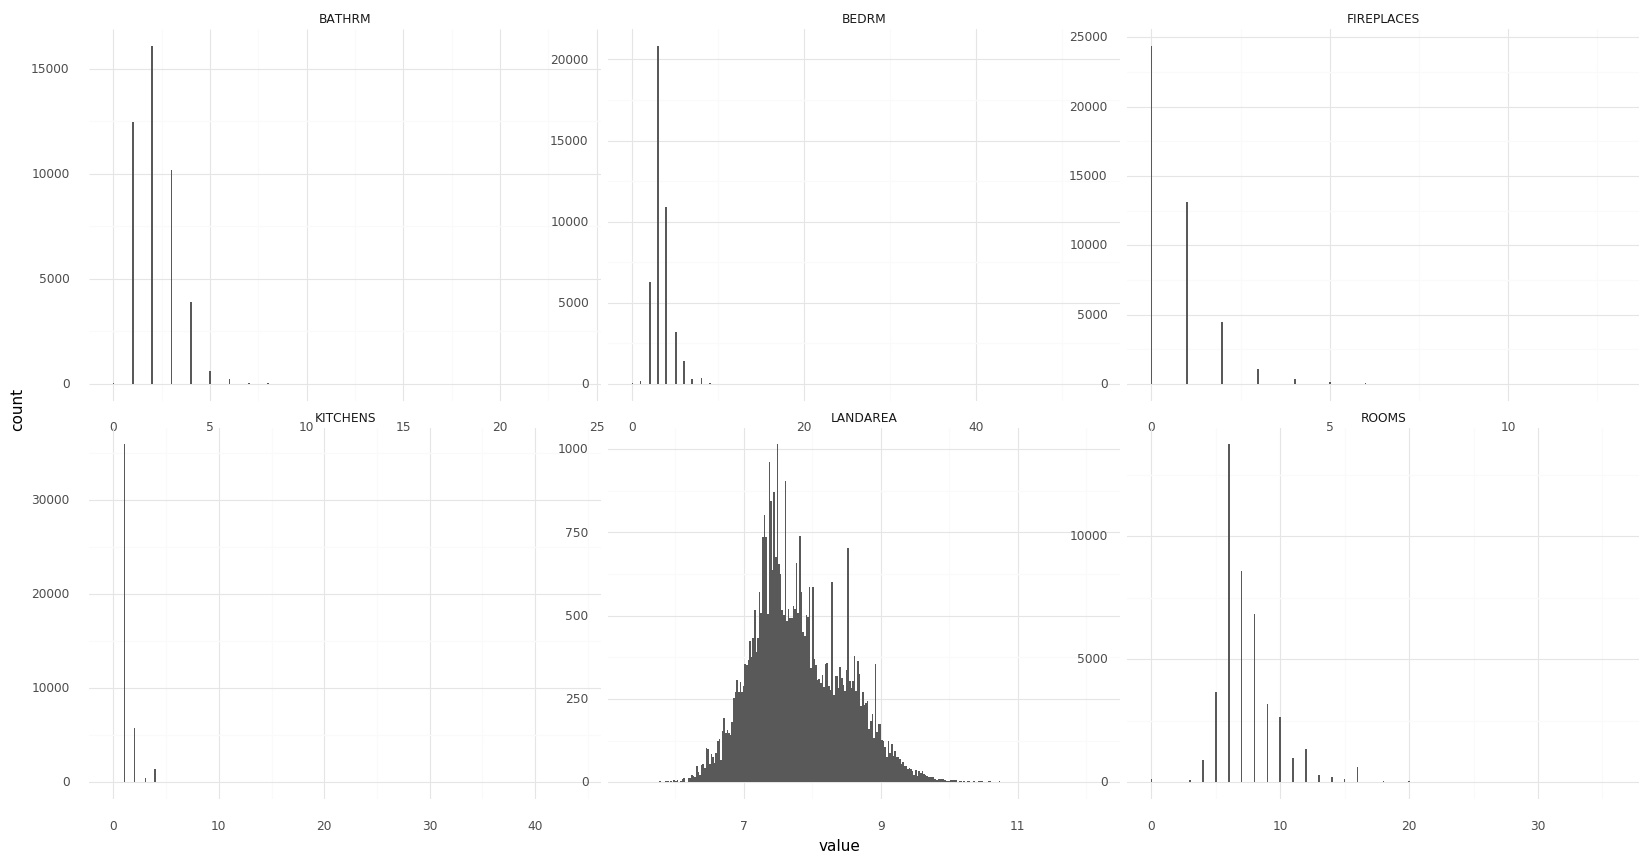

<ggplot: (-9223371911358982256)>

In [21]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (20,10)) 
) 

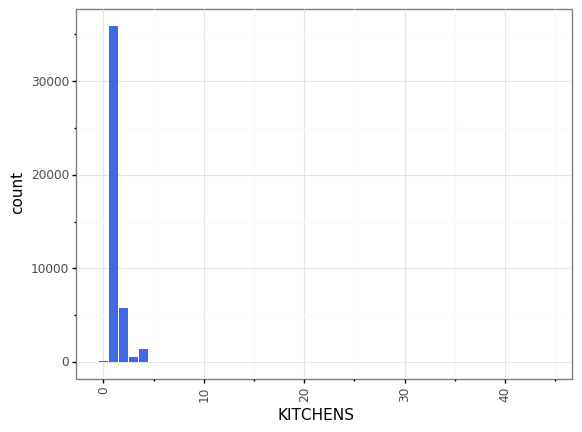

<ggplot: (-9223371911236637836)>

In [22]:
# view distribution of kitchens feature
(ggplot(data=train_X[['KITCHENS']],
           mapping=aes(x='KITCHENS'))
    + geom_bar(fill="royalblue")
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90))
)

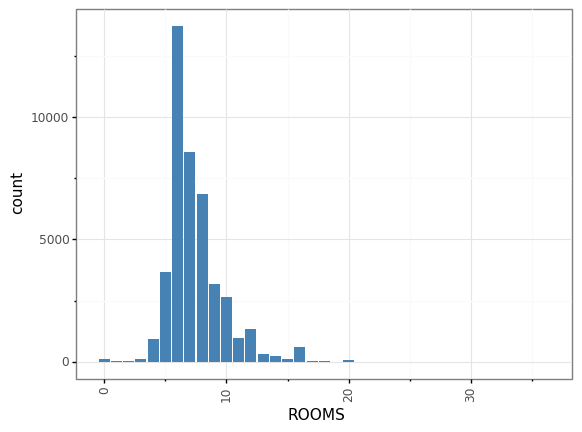

<ggplot: (-9223371911358383096)>

In [23]:
# view distribution of rooms feature
(ggplot(data=train_X[['ROOMS']],
           mapping=aes(x='ROOMS'))
    + geom_bar(fill="steelblue")
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90))
)

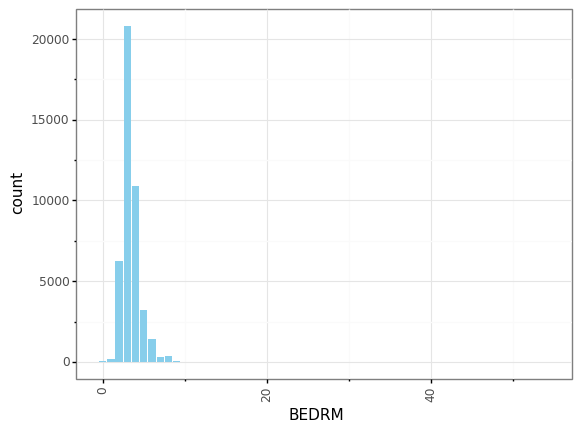

<ggplot: (-9223371911358983840)>

In [24]:
# view distribution of bedrooms feature
(ggplot(data=train_X[['BEDRM']],
           mapping=aes(x='BEDRM'))
    + geom_bar(fill="skyblue")
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90))
)

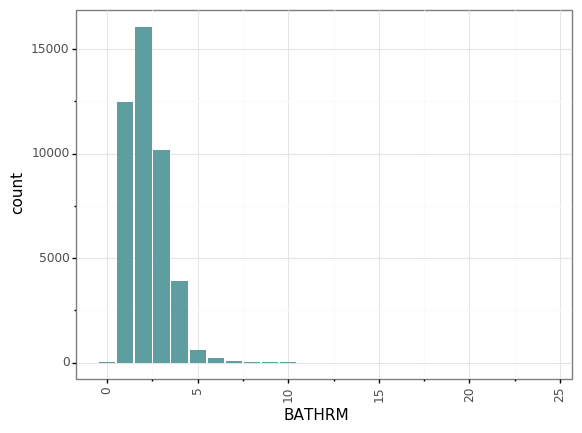

<ggplot: (-9223371911357993596)>

In [25]:
# view distribution of bathrooms feature
(ggplot(data=train_X[['BATHRM']],
           mapping=aes(x='BATHRM'))
    + geom_bar(fill="cadetblue")
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90))
)

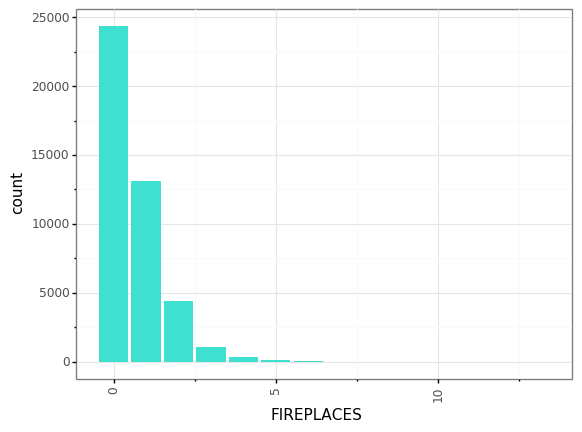

<ggplot: (-9223371911357963752)>

In [26]:
# view distribution of fireplaces feature
(ggplot(data=train_X[['FIREPLACES']],
           mapping=aes(x='FIREPLACES'))
    + geom_bar(fill="turquoise")
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90))
)

Insights from the plots above:
- Scale will be an issue so we need to preprocess.
- All the variables except for `LANDAREA` follow a binomial distribution.
- `LANDAREA` follows a continuous distribution.

### Look at the outcome `PRICE` and see if there are any red flags. 

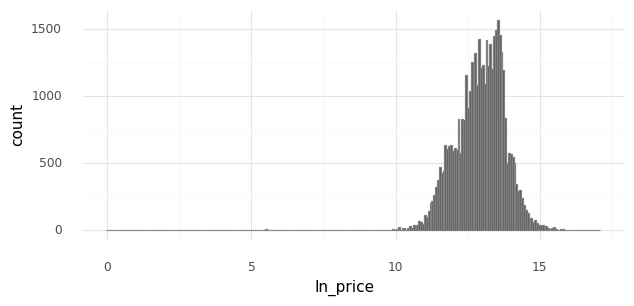

<ggplot: (-9223371911357783096)>

In [27]:
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram(color="gray") +
    theme_minimal() +
    labs(x="ln_price")+
    theme(figure_size = (7,3)) 
)

### Look at how the predictors relate to the outcome.

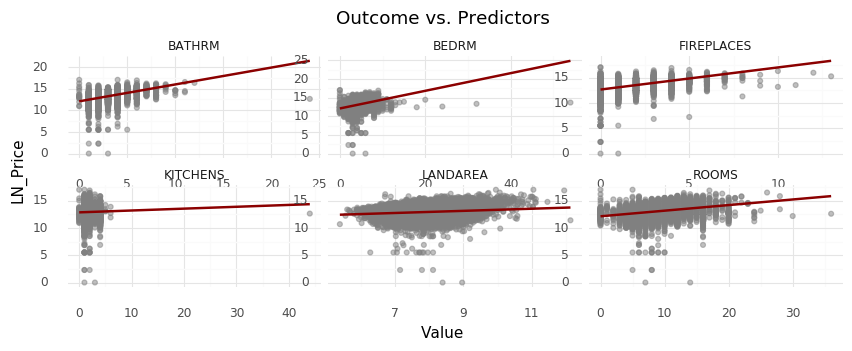

<ggplot: (-9223371911356350104)>

In [28]:
D = train_X.copy()
D['PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["PRICE"]),
           aes(x="value",y="PRICE"))+
    geom_point(alpha=.5, color="gray") +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="darkred") +
    theme_minimal() +
    labs(y="LN_Price",x="Value",title="Outcome vs. Predictors")+
    theme(figure_size = (10,3)) 
)

# Modeling Pipeline

In [29]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','ROOMS','BEDRM','KITCHENS','FIREPLACES','LANDAREA'])])

# (3) Create model pipe (for the model, leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'KITCHENS',
                                                                          'FIREPLACES',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor

### Check the best fit score from the scan.

In [30]:
search.best_score_ # Mean out-of-sample (CV) error

-0.4610450502272103

### Look at the best model

In [31]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [32]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [33]:
m.mean_squared_error(test_y,pred_y)

0.4577977571972246

In [34]:
m.r2_score(test_y,pred_y)

0.38062102313542234

Visualize

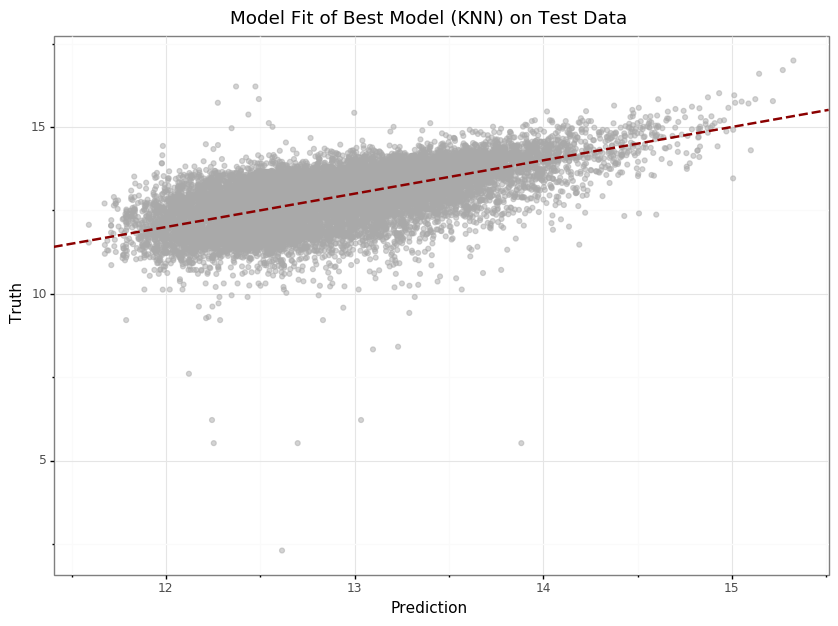

<ggplot: (-9223371911229940824)>

In [35]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (KNN) on Test Data")+
    theme(figure_size=(10,7))
)

## Run models separately and compare

### Pre-Processing

In [36]:
# Rescale training data
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [37]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,ROOMS,BEDRM,KITCHENS,FIREPLACES,LANDAREA
0,0.125000,0.250000,0.074074,0.022727,0.000000,0.345337
1,0.083333,0.194444,0.055556,0.022727,0.076923,0.425790
2,0.083333,0.250000,0.074074,0.022727,0.076923,0.531400
3,0.041667,0.166667,0.055556,0.022727,0.000000,0.375461
4,0.083333,0.305556,0.074074,0.022727,0.000000,0.335982
...,...,...,...,...,...,...
43568,0.041667,0.138889,0.037037,0.022727,0.076923,0.140818
43569,0.083333,0.194444,0.055556,0.022727,0.076923,0.284773
43570,0.083333,0.250000,0.074074,0.022727,0.153846,0.275519
43571,0.125000,0.166667,0.055556,0.045455,0.076923,0.207292


In [38]:
# create a KFold generator to ensure we're using the same break points when training the model
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

In [39]:
# use mean squared error as our performance metric
use_metrics = ["neg_mean_squared_error"]

### Run the Models

#### Linear Model

In [40]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### KNN

In [41]:
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Decision Tree

In [42]:
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Plotting a Decision Tree

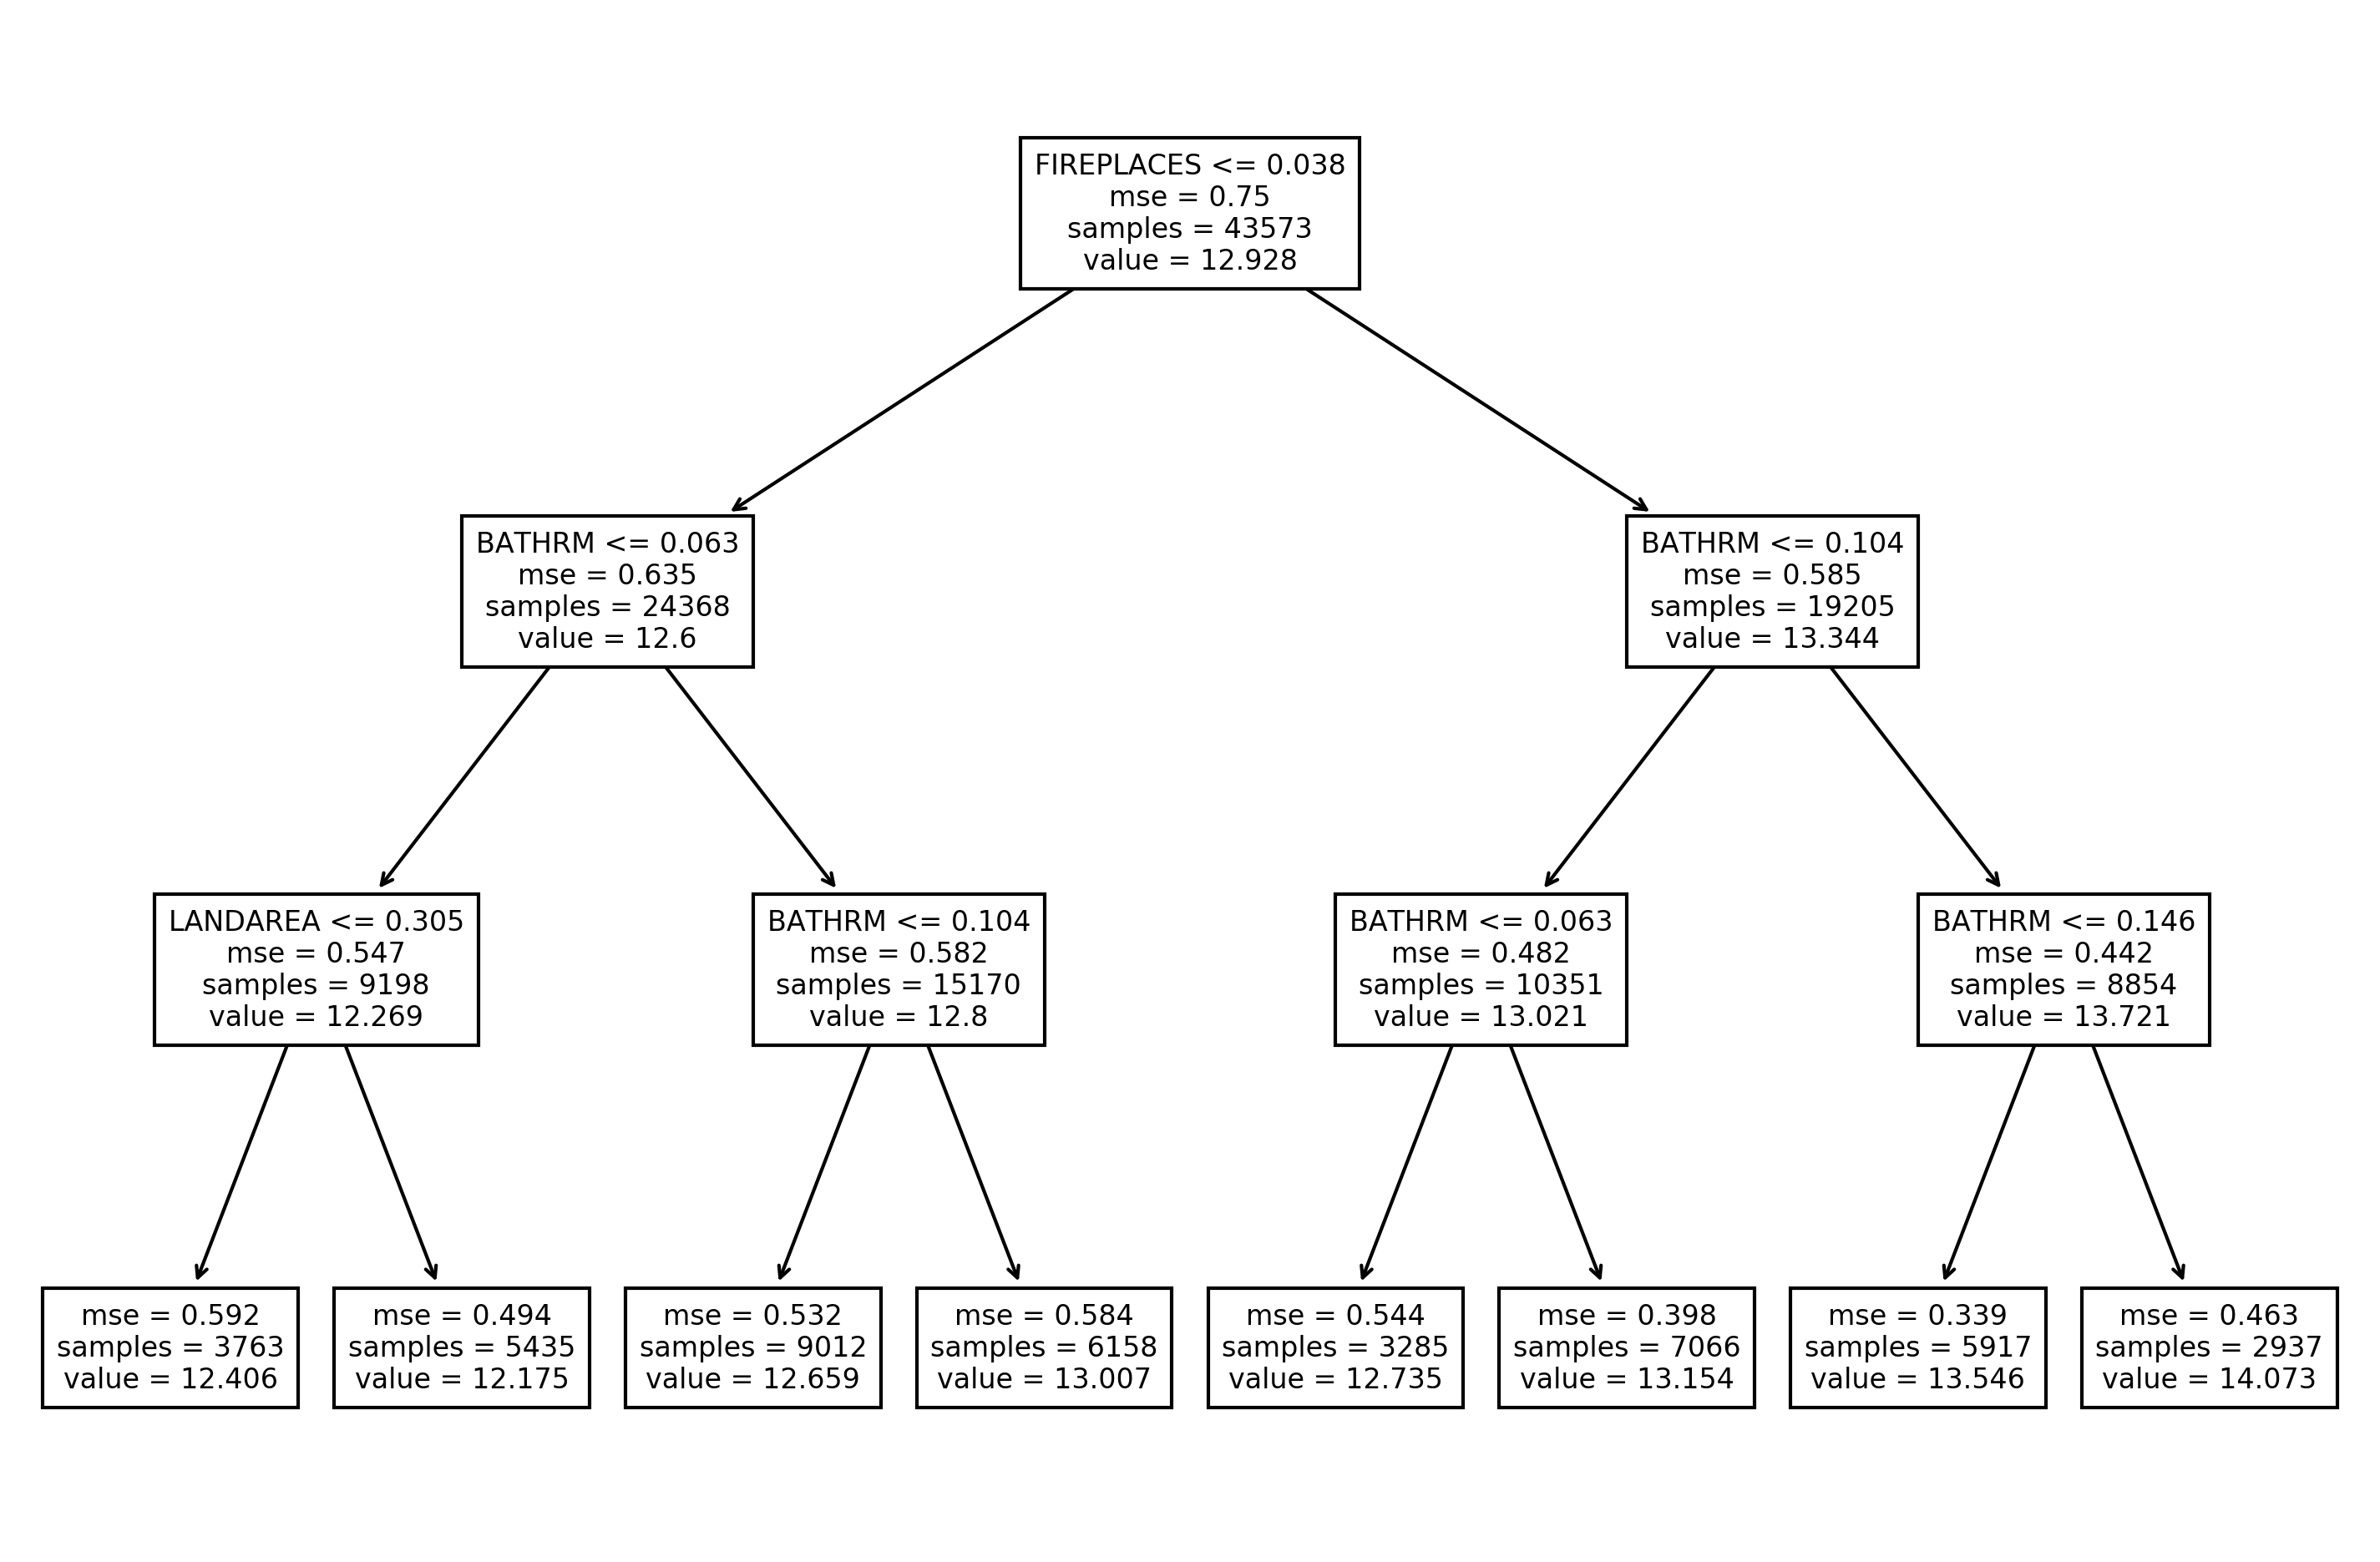

In [43]:
# Initialize the modeling object
mod = DTree(max_depth=3) 

# Fit the mode
mod.fit(train_X,train_y) 

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

#### Bagging

In [44]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Random Forest

In [45]:
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Compare Models

In [46]:
# Collect all the metrics as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.517060
1,lm,0.475406
2,lm,0.474144
3,lm,0.498667
4,lm,0.488634
5,knn,0.525011
6,knn,0.517654
7,knn,0.508652
8,knn,0.524979
9,knn,0.527306


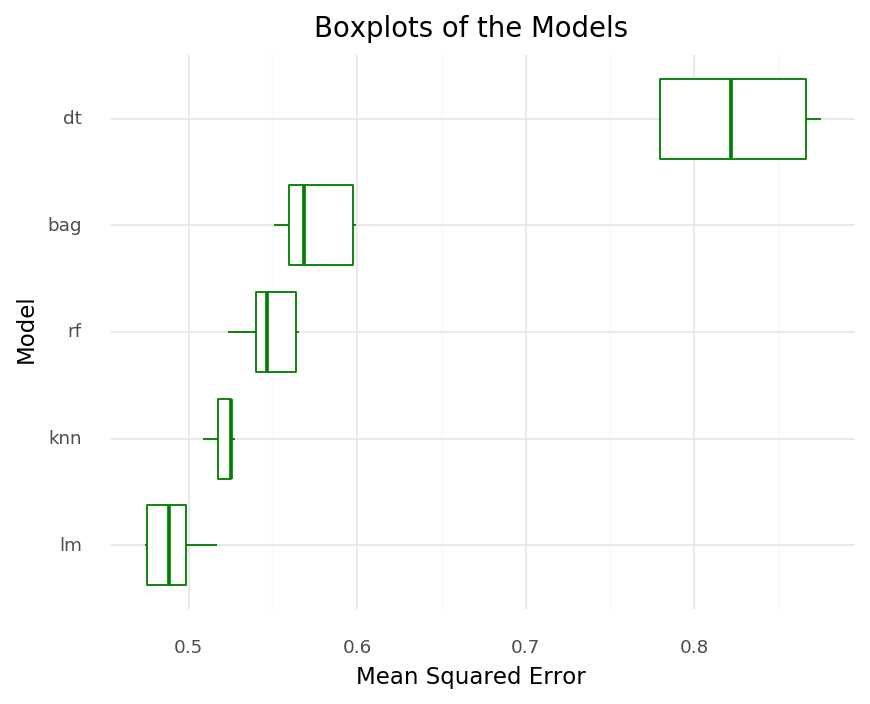

<ggplot: (-9223371911357806988)>

In [47]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot(color="green") +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error", title='Boxplots of the Models') +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Lower is better. The linear model appears to do the best here.  

### Model Tuning 

#### KNN

In [48]:
# Initialize the model class
mod = KNN() 

# report all the available tunning parameters 
mod.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [49]:
# create dictionary of parameter values that we want to explore
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [50]:
# pass dictionary to grid search
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [51]:
# fit model
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

View best fitting parameters:

In [52]:
tune_knn.best_params_

{'n_neighbors': 75}

In [53]:
tune_knn.best_score_

-0.4578146129934961

### Decision Tree

In [54]:
# get parameters
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [55]:
# pass parameter to grid search 
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [56]:
# fit model
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

View best fitting parameters:

In [57]:
tune_dt.best_params_

{'max_depth': 6}

In [58]:
tune_dt.best_score_

-0.462732616690935

### Random Forest

In [59]:
# get parameters
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [60]:
# define and pass parameters to grid search
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2,3,4,5]} # Only have six predictors in total 

tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [61]:
# fit model
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3],
                         'max_features': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

View best fitting parameters:

In [62]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 4, 'n_estimators': 1000}

In [63]:
tune_rf.best_score_

-0.4805162992512515

### Compare Models

In [64]:
# df of the LM model
lm_dat = collect_scores[collect_scores['Model']=='lm']

# store average MSE 
lm_best_score = lm_dat.MSE.mean()*-1

In [65]:
# df of the bag model
bag_dat = collect_scores[collect_scores['Model']=='bag']

# store average MSE 
bag_best_score = bag_dat.MSE.mean()*-1

In [66]:
# create dict of best scores
best_parameters = \
dict(lm = lm_best_score,
    knn = tune_knn.best_score_,
    dt = tune_dt.best_score_,
    bag = bag_best_score,
    rf = tune_rf.best_score_)

best_parameters

{'lm': -0.4907823380984504,
 'knn': -0.4578146129934961,
 'dt': -0.462732616690935,
 'bag': -0.574945507174191,
 'rf': -0.4805162992512515}

In [67]:
# Convert to a data frame
df = pd.DataFrame(list(best_parameters.items()),columns = ['Model','MSE'])

# sort data frame
df.sort_values(by=['MSE'], inplace=True)

In [68]:
# display df
df

,Model,MSE
3,bag,-0.574946
0,lm,-0.490782
4,rf,-0.480516
2,dt,-0.462733
1,knn,-0.457815


In [69]:
# get the lowest MSE and model
df[df.MSE == df.MSE.max()]

,Model,MSE
1,knn,-0.457815


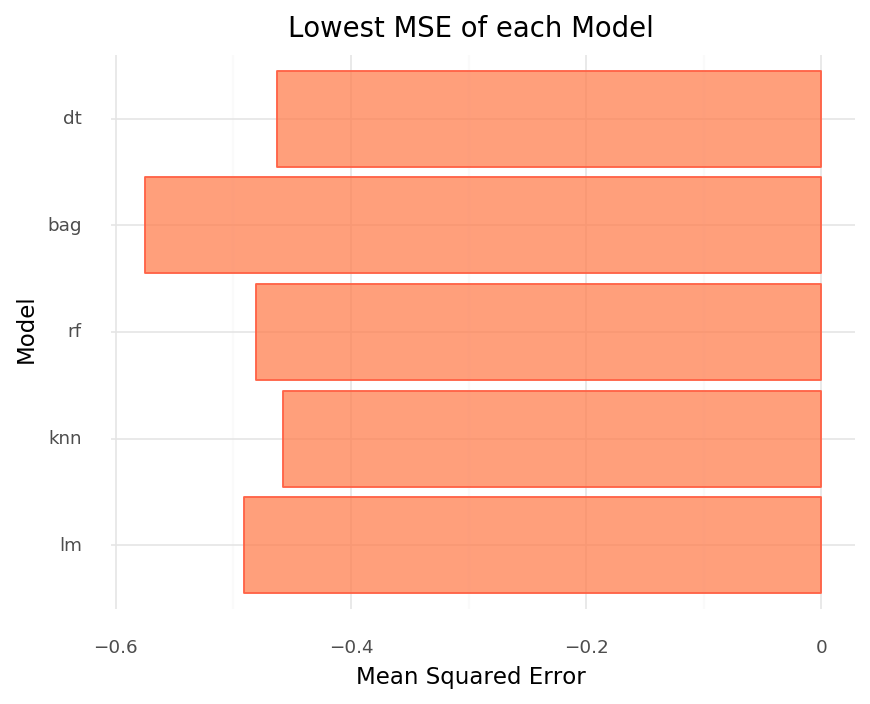

<ggplot: (-9223371911358009540)>

In [70]:
# plot MSEs
(
    ggplot(df,
          aes(x="Model",y="MSE")) +
    geom_bar(stat = "identity", color = "tomato", fill="coral", alpha=0.75) +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error", title="Lowest MSE of each Model") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

KNN performed the best among the 5 models as it has the lowest MSE.